# Virtual Training Assitant demo

This notebook contains a demo of our Virtual Training Assitant.

The major part of the code presents our MVP: An exercise repetition counter with feedback using a reference video, based on the BlazePose 3D human pose estimator.

At the end of the notebook, we have also attached the extra code that was not included in the final solution:
* The alternative pose estimation using the YOLOv7 model (Does not work because of very high resource consumptions. If you use it, you will crash your Colab Runtime).
* The exercise classifier: Our exercise classifier using an LSTM network. Due to the lack of data, this classifier has very low accuracy and is practically useless.

In [1]:
# The library for using the BlazePose pose estimator
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import mediapipe as mp
import numpy as np
import cv2

## Dataclasses for storing the pose keypoints

We have a class for storing the Human Pose and calculating the joint angles, and one for aggregating the data from different frames to obtain a timeseries of angles.

In [3]:
"""
Dataclass that encompasses the keypoints of a human pose
"""
from dataclasses import dataclass
from typing import List
import numpy as np


@dataclass
class HumanPose:
    # Generic version with just a list
    raw_points: List
    
    left_shoulder: np.ndarray
    right_shoulder: np.ndarray

    left_elbow: np.ndarray
    right_elbow: np.ndarray

    left_wrist: np.ndarray
    right_wrist: np.ndarray

    left_hip: np.ndarray
    right_hip: np.ndarray

    left_knee: np.ndarray
    right_knee: np.ndarray

    left_ankle: np.ndarray
    right_ankle: np.ndarray


    def __init__(self, points: List[float] = None, **kwargs):
        """
        Converts the list of points to an object (depends on the pose estimation algorithm)
        """
        # The raw version
        if points is not None:
            self.raw_points = points

        else:
            self.right_elbow = kwargs["right_elbow"]
            self.right_wrist = kwargs["right_wrist"]
            self.right_shoulder = kwargs["right_shoulder"]
            self.right_hip = kwargs["right_hip"]
            self.right_knee = kwargs["right_knee"]
            self.right_ankle = kwargs["right_ankle"]

            self.left_elbow = kwargs["left_elbow"]
            self.left_wrist = kwargs["left_wrist"]
            self.left_shoulder = kwargs["left_shoulder"]
            self.left_hip = kwargs["left_hip"]
            self.left_knee = kwargs["left_knee"]
            self.left_ankle = kwargs["left_ankle"]

            self.right_elbow_visibility = kwargs.get("right_elbow_visibility")
            self.right_wrist_visibility = kwargs.get("right_wrist_visibility")
            self.right_shoulder_visibility = kwargs.get("right_shoulder_visibility")
            self.right_hip_visibility = kwargs.get("right_hip_visibility")
            self.right_knee_visibility = kwargs.get("right_knee_visibility")
            self.right_ankle_visibility = kwargs.get("right_ankle_visibility")

            self.left_elbow_visibility = kwargs.get("left_elbow_visibility")
            self.left_wrist_visibility = kwargs.get("left_wrist_visibility")
            self.left_shoulder_visibility = kwargs.get("left_shoulder_visibility")
            self.left_hip_visibility = kwargs.get("left_hip_visibility")
            self.left_knee_visibility = kwargs.get("left_knee_visibility")
            self.left_ankle_visibility = kwargs.get("left_ankle_visibility")

    # Bunch of utility functions
    def _angle(self, first_point_name, middle_point_name, second_point_name) -> float:
        """
        Calculates the angles formed by the given 3 keypoints

        Returns:
            - angle (float): The angle in radians
        """
        # Get the vectors
        x = self.__dict__[first_point_name][:2]- self.__dict__[middle_point_name][:2]
        y = self.__dict__[second_point_name][:2] - self.__dict__[middle_point_name][:2]

        
        # Normalize the vectors
        x /= np.linalg.norm(x)
        y /= np.linalg.norm(y)

        angle = np.arccos(np.clip(np.dot(x, y), -1.0, 1.0))
        return angle

    # TODO: Add more functions for specific angles
    @property
    def right_shoulder_angle(self):
        return self._angle("right_elbow", "right_shoulder", "right_hip")

    @property
    def left_shoulder_angle(self):
        return self._angle("left_elbow", "left_shoulder", "left_hip")

    @property
    def right_elbow_angle(self):
        return self._angle("right_wrist", "right_elbow", "right_shoulder")

    @property
    def left_elbow_angle(self):
        return self._angle("left_wrist", "left_elbow", "left_shoulder")

    @property
    def right_hip_angle(self):
        return self._angle("right_shoulder", "right_hip", "right_knee")

    @property
    def left_hip_angle(self):
        return self._angle("left_shoulder", "left_hip", "left_knee")

    @property
    def right_knee_angle(self):
        return self._angle("right_hip", "right_knee", "right_ankle")

    @property
    def left_knee_angle(self):
        return self._angle("left_hip", "left_knee", "left_ankle")

    
    # This is less useful when using 3D points    
    def _distance(self, first_point_name, second_point_name):
        x = self.__dict__[first_point_name]
        y = self.__dict__[second_point_name]

        return np.linalg.norm(x-y)

In [4]:
@dataclass
class HumanPoseEvolution:
    timeseries: List[HumanPose]

    def __init__(self):
        self.timeseries = []
        self.timestamps = []

        self.angles_cache = None

        self.skip_first = 0

    def add(self, timestamp: float, pose: HumanPose):
        self.timeseries.append(pose)
        self.timestamps.append(timestamp)

    def right_elbow_angle_evolution(self):
        result = []

        for pose in self.timeseries:
            result.append(pose.right_elbow_angle)

        return zip(self.timestamps, result)

    def get_all_angles(self):
        # Check the cache to avoid recalculations
        if self.angles_cache is not None:
            return self.angles_cache

        result = {
            "right_elbow_angle": [],
            "left_elbow_angle": [],
            "right_shoulder_angle": [],
            "left_shoulder_angle": [],
            "right_hip_angle": [],
            "left_hip_angle": [],
            "right_knee_angle": [],
            "left_knee_angle": [],
        }

        visibilities = {
            "right_elbow_angle": [],
            "left_elbow_angle": [],
            "right_shoulder_angle": [],
            "left_shoulder_angle": [],
            "right_hip_angle": [],
            "left_hip_angle": [],
            "right_knee_angle": [],
            "left_knee_angle": [],
        }

        for pose in self.timeseries[self.skip_first:]:
            result["right_elbow_angle"].append(pose.right_elbow_angle)
            result["left_elbow_angle"].append(pose.left_elbow_angle)
            result["right_shoulder_angle"].append(pose.right_shoulder_angle)
            result["left_shoulder_angle"].append(pose.left_shoulder_angle)
            result["right_hip_angle"].append(pose.right_hip_angle)
            result["left_hip_angle"].append(pose.left_hip_angle)
            result["right_knee_angle"].append(pose.right_knee_angle)
            result["left_knee_angle"].append(pose.left_knee_angle)

        # ZIP all of the angles with the timestamps
        for k, v in result.items():
            result[k] = list(zip(self.timestamps[self.skip_first:], v))


        self.angles_cache = result

        return result

## Mediapipe Pose Estimator

The Pose estimator using the BlazePose model offered by the MediaPipe library

In [5]:
import abc


class BaseEstimator(metaclass=abc.ABCMeta):
    """
    Abstract class for a human pose estimator
    """

    @classmethod
    def __subclasshook__(cls, subclass):
        """
        
        """
        methods = [
            'find_pose'
        ]
        for i in methods:
            if not hasattr(subclass, i) or not callable(subclass.__dict__[i]):
                return NotImplemented
        return True

    @abc.abstractmethod
    def __init__(self, *args, **kwargs):
        raise NotImplementedError

    @abc.abstractmethod
    def find_pose(self, image):
        raise NotImplementedError

In [6]:
class MediaPipeEstimator(BaseEstimator):
    """
    Human Pose estimator using the BlazePose model
    """
    def __init__(self):
        # The pose estimator object
        self.pose = mp.solutions.pose.Pose()

        # The drawing utility for drawing the keypoints onto frames
        self.draw = mp.solutions.drawing_utils


    def find_pose(self, image, draw=False) -> HumanPose:
        """
        Args:
          - image: Image to proces

        Returns:
          - HumanPose, Image: The keypoints of the human pose, with the processed image
          If draw=True, the processed image will also have the keypoints drawn on it
        """
        result = self.pose.process(image)

        # In case we could not detect the pose
        if not result.pose_landmarks:
            return None, image

        # Draw the keypoints
        if draw:
            self.draw.draw_landmarks(image, result.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

            for ind, lm in enumerate(result.pose_landmarks.landmark):
                h, w, c = image.shape
                cx, cy =  int(lm.x*w), int(lm.y * h)
                cv2.circle(image, (cx, cy), 5, (255, 0, 0), cv2.FILLED)


        landmarks = list(result.pose_landmarks.landmark)
        return HumanPose(
            left_shoulder=self._landmark_to_coordinate(landmarks[11]),
            right_shoulder=self._landmark_to_coordinate(landmarks[12]),
            left_elbow=self._landmark_to_coordinate(landmarks[13]),
            right_elbow=self._landmark_to_coordinate(landmarks[14]),
            left_wrist=self._landmark_to_coordinate(landmarks[15]),
            right_wrist=self._landmark_to_coordinate(landmarks[16]),
            left_hip=self._landmark_to_coordinate(landmarks[23]),
            right_hip=self._landmark_to_coordinate(landmarks[24]),
            left_knee=self._landmark_to_coordinate(landmarks[25]),
            right_knee=self._landmark_to_coordinate(landmarks[26]),
            left_ankle=self._landmark_to_coordinate(landmarks[27]),
            right_ankle=self._landmark_to_coordinate(landmarks[28]),

            left_shoulder_visibility=self._landmark_visibility(landmarks[11]),
            right_shoulder_visibility=self._landmark_visibility(landmarks[12]),
            left_elbow_visibility=self._landmark_visibility(landmarks[13]),
            right_elbow_visibility=self._landmark_visibility(landmarks[14]),
            left_wrist_visibility=self._landmark_visibility(landmarks[15]),
            right_wrist_visibility=self._landmark_visibility(landmarks[16]),
            left_hip_visibility=self._landmark_visibility(landmarks[23]),
            right_hip_visibility=self._landmark_visibility(landmarks[24]),
            left_knee_visibility=self._landmark_visibility(landmarks[25]),
            right_knee_visibility=self._landmark_visibility(landmarks[26]),
            left_ankle_visibility=self._landmark_visibility(landmarks[27]),
            right_ankle_visibility=self._landmark_visibility(landmarks[28])
        ), image

    @staticmethod
    def _landmark_to_coordinate(landmark):
        """
        Convert the landmarks to 3D vectors
        """
        return np.array([
            landmark.x,
            landmark.y,
            landmark.z
        ])

    @staticmethod
    def _landmark_visibility(landmark):
        return landmark.visibility


## Rep Counter

The implementation of our repetition counting algorithm

In [7]:
from scipy.signal import argrelextrema

def running_mean(x, N):
    """
    Apply a moving average filter to x with window size N
    """
    return np.convolve(x, np.ones(N)/N, mode='valid')

class RepCounter:
    def __init__(self, evolution: HumanPoseEvolution):
        self.evolution = evolution

    def _count_single_angle_reps(self, sorted_extrema, min_range, max_range, min_rep_duration=1):
        """
        Given the extrema of the angle, the accepted range and minimum duration, 
        this function calculates the number of reps
        """

        # Calculate the valid extrema (extrema that cross the range thresholds)
        valid_extrema = sorted_extrema[:1]

        minima = None
        for timestamp, value in sorted_extrema[1:-1]:
            if minima is None:
                if value <= min_range:
                    minima = True
                    valid_extrema.append((timestamp, value))
                elif value >= max_range:
                    minima = False
                    valid_extrema.append((timestamp, value))
                continue

            if minima is True and value >= max_range:
                valid_extrema.append((timestamp, value))
                minima = False

            if minima is False and value <= min_range:
                valid_extrema.append((timestamp, value))
                minima = True

        valid_extrema.append(sorted_extrema[-1])

        # Count the reps
        # One rep is counted whenever the signal crosses the thresholds twice (one in each direction)
        reps = []
        counted = False
        for ind, (timestamp, value) in enumerate(valid_extrema):
            if ind + 2 >= len(valid_extrema):
                break

            if counted:
                counted = False
                continue
            
            reps.append(valid_extrema[ind+2][0] - timestamp)
            counted = True

        if len(reps) == 0:
            return valid_extrema, 0

        # Filter the reps by their duration
        average_length = sum(reps)/len(reps)

        # Exclude reps that are too short
        rep_count = len(list(filter(lambda x: x > 0.75*average_length, reps)))

        new_average_length = sum(reps)/len(reps)

        return valid_extrema, rep_count, new_average_length

    

    def _process_angle(self, timeseries):
        """
        Processes the signal and calculates the reps
        """

        timestamps, values = zip(*timeseries)
        values = np.array(values)

        # Apply MA filter
        sampling_rate = 1/(timestamps[1] - timestamps[0])

        ma_window = int(sampling_rate*0.5)

        values = running_mean(values, ma_window)


        # Find the local extrema of the timeseries
        maxima = argrelextrema(values, np.greater)[0]
        minima = argrelextrema(values, np.less)[0]


        # Calculate the absolute angle range
        absolute_max = np.max(values)
        absolute_min = np.min(values)

        angle_range = absolute_max - absolute_min

        # Don't count this joint angle if the range is too small
        if angle_range < 0.5:
            return [], angle_range, 0, list(zip(timestamps, values.tolist())), 0
        
        

        extrema = []
        for x in maxima:
            extrema.append([timestamps[x], values[x]])

        for x in minima:
            extrema.append([timestamps[x], values[x]])

        # Add the start and end points to the extrema
        extrema.append([timestamps[-1], values[-1]])
        extrema.append([timestamps[0], values[0]])


        sorted_extrema = sorted(extrema, key=lambda x: x[0])

        # Get the rep information
        valid_extrema, reps, average_length = self._count_single_angle_reps(
                                sorted_extrema, 
                                absolute_min + 0.3*(angle_range), 
                                absolute_max - 0.3*(angle_range))

        return valid_extrema, angle_range, reps, list(zip(timestamps, values.tolist())), average_length

    def count_reps(self):
        """
        Counts the reps using all the angle timeseries
        """
        angles = self.evolution.get_all_angles()

        # The smoothed timeseries after the MA filter
        smoothed_results = {}

        # The extrema for each timeseries
        angle_extrema = {}

        # The potential rep counts with their occurences
        potential_rep_counts = {}

        # The angle ranges
        range_information = {}

        # The potential rep values
        reps_values = []

        for name, timeseries in angles.items():
            extrema, range, reps, smoothed, rep_length = self._process_angle(timeseries)


            if reps:
                reps_values.append(reps)

            smoothed_results[name] = smoothed
            if len(extrema):
                angle_extrema[name] = extrema

            if reps not in potential_rep_counts:
              potential_rep_counts[reps] = {
                  "score": 0,
                  "count": 0,
                  "length": 0 
              }

            potential_rep_counts[reps]["score"] += range
            potential_rep_counts[reps]["count"] += 1
            potential_rep_counts[reps]["length"] += rep_length

            range_information[name] = range

        # Calculate the score for each potential rep value
        rep_scores = {}

        for k, v in potential_rep_counts.items():
          rep_scores[k] = v["score"]/v["count"]


        # Calculate the final rep prediction (maximum using the given scores)
        result = list(rep_scores.keys())[0]
        for k, v in rep_scores.items():
          if v > rep_scores[result]:
            result = k
            
        average_rep_length = potential_rep_counts[result]["length"]/potential_rep_counts[result]["count"]

        return smoothed_results, angle_extrema, result, average_rep_length, range_information


## Finding the pose from a video

Calculating the pose for an entire video

In [8]:
# Library for saving video files
!pip install sk-video

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import cv2

from datetime import datetime
import matplotlib.pyplot as plt
import time


import skvideo.io
import numpy as np


def video_to_human_pose_evolution(video_path, model="blaze_pose", save_video=True):
    """
    Calculates the pose from a given video (video path)

    Also saves a video with the detected pose keypoints by default

    Return a HumanPoseEvolution object
    """
    estimator = None
    if model == "blaze_pose":
        estimator = MediaPipeEstimator()
    elif model == "yolo":
        estimator = YOLOEstimator()
    else:
        raise ValueError("The pose model should be either 'blaze_pose' or 'yolo'")

    evolution = HumanPoseEvolution()

    cap = cv2.VideoCapture(video_path)

    # This part is for saving the video
    if save_video:
      video_save_path = f"video_pose_{model}.mp4"
      fps = 30
      vwriter = skvideo.io.FFmpegWriter(video_save_path, 
                          inputdict={'-r': str(fps)},
                          outputdict={'-r': str(fps), '-c:v': 'libx264', '-preset': 'ultrafast', '-pix_fmt': 'yuv444p'})

    while True:
        success, img = cap.read()
        if not success:
            continue
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        results, img_rgb = estimator.find_pose(img_rgb, draw=True)

        if save_video:
          vwriter.writeFrame(img_rgb)

        if results is not None:
            timestamp = cap.get(cv2.CAP_PROP_POS_MSEC)/1000
            if timestamp != 0:
                evolution.add(timestamp, results)


        if cv2.waitKey(1) == 27:
            break
        if cap.get(cv2.CAP_PROP_POS_FRAMES) == cap.get(cv2.CAP_PROP_FRAME_COUNT):
            # If the number of captured frames is equal to the total number of frames,
            # we stop
            break

    cap.release()
    cv2.destroyAllWindows() # destroy all opened windows

    # Saving pose video
    if save_video:
      vwriter.close()
    return evolution

## Results

Here we test the code using video files

In [10]:
# !gdown https://drive.google.com/file/d/1Vbkk33ml98vP89uHiqZFA2NR7W0gNbN9/view?usp=sharing
# Deadlift videos with reference

!gdown https://drive.google.com/uc?id=1NsKyX40QHR8EMIvtHfezvwSvyTMLd-RT
!gdown https://drive.google.com/uc?id=12ir8kRTu6AzbWCHUSLMTMvvYFFHQXmnK
#  Reference
!gdown https://drive.google.com/uc?id=1jcty1KpKBthGzrCFd2lxKWm2W4AJ5NG7

# Incline bench press videos
!gdown https://drive.google.com/uc?id=1aSbl7-KNxbLAE6KYOrDudlQ6tSg2qHQL
# ref
!gdown https://drive.google.com/uc?id=1vtPc1VX0KwyxRJl_8GhkLmOxpd5YaO0S

Downloading...
From: https://drive.google.com/uc?id=1NsKyX40QHR8EMIvtHfezvwSvyTMLd-RT
To: /content/deadlift_3.mp4
100% 1.69M/1.69M [00:00<00:00, 146MB/s]
Downloading...
From: https://drive.google.com/uc?id=12ir8kRTu6AzbWCHUSLMTMvvYFFHQXmnK
To: /content/deadlift_2.mp4
100% 3.51M/3.51M [00:00<00:00, 202MB/s]
Downloading...
From: https://drive.google.com/uc?id=1jcty1KpKBthGzrCFd2lxKWm2W4AJ5NG7
To: /content/deadlift_reference.mp4
100% 1.03M/1.03M [00:00<00:00, 105MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aSbl7-KNxbLAE6KYOrDudlQ6tSg2qHQL
To: /content/incline_bp.mp4
100% 7.70M/7.70M [00:00<00:00, 159MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vtPc1VX0KwyxRJl_8GhkLmOxpd5YaO0S
To: /content/incline_bp_reference.mp4
100% 176k/176k [00:00<00:00, 83.6MB/s]


In [11]:
video_path = "./incline_bp.mp4"
reference_video_path = "./incline_bp_reference.mp4"

In [12]:
# Calculate reps from the pose of video
evolution = video_to_human_pose_evolution(video_path)

timeseries = evolution.right_elbow_angle_evolution()
all_timeseries = evolution.get_all_angles()
counter = RepCounter(evolution)

all_timeseries, all_extrema, reps, length, range_info = counter.count_reps()

print(f"You did {reps} reps with an average rep duration of {length:.2f} seconds")


# Evaluating the exercise speed using a reference video
reference_evolution = video_to_human_pose_evolution(reference_video_path, save_video=False)

counter = RepCounter(reference_evolution)

_, _, _, reference_length, reference_range_info = counter.count_reps()

length_diff_percentage = 100*(abs(length - reference_length)/reference_length)

feedback = f"""
FEEDBACK:
- On average, your reps were {length_diff_percentage:.2f}% {'slower' if length > reference_length else 'faster'} then the reference exercise video.
"""
print(feedback)

You did 4 reps with an average rep duration of 2.20 seconds

FEEDBACK:
- On average, your reps were 78.52% slower then the reference exercise video.



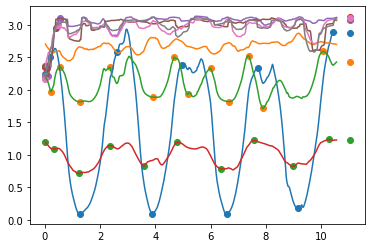

In [13]:
# Plotting the angles evolution with their extrema

for k, v in all_timeseries.items():
    plt.plot(*list(zip(*v)))
    if k in all_extrema:
        plt.scatter(*list(zip(*all_extrema[k])))

plt.show()

## Exercise classifier

Code for loading our exercise classifier, this is just a showcase of our work on the classifier. Do not expect this to predict the exercise correctly!

In [14]:
!gdown https://drive.google.com/uc?id=1U7_gwzcLJsVnxAeQVXHfO7F8OHqpfiYV

Downloading...
From: https://drive.google.com/uc?id=1U7_gwzcLJsVnxAeQVXHfO7F8OHqpfiYV
To: /content/exercise_classifier.pt
100% 6.69k/6.69k [00:00<00:00, 8.66MB/s]


In [15]:
import torch
from torch import nn
from torch.autograd import Variable 

NUM_CLASSES = 6

class VideoExerciseClassifier(nn.Module):
  def __init__(self):
    super().__init__()

    self.num_layers = 2

    self.hidden_size = 8
    self.input_size = 50

    self.relu = nn.ReLU()

    self.lstm = nn.LSTM(8, 8, num_layers=2, batch_first=True)
    self.dense = nn.Linear(self.hidden_size, NUM_CLASSES)


  def forward(self,x):
    h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
    c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
    # Propagate input through LSTM
    output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
    out = self.relu(hn[-1])
    out = self.dense(out) #first Dense
    return out
  

model = VideoExerciseClassifier()
model.load_state_dict(torch.load("./exercise_classifier.pt", map_location=torch.device('cpu')))
model.eval()


def predict_exercise(all_timeseries):
    sequence = []
    try:
      for i in range(50):
          vec = []

          for k, v, in all_timeseries.items():
              vec.append(v[i][1])

          sequence.append(vec)

    except IndexError:
       return "Unknown exercise (not enough frames to predict)"
       
    model_input = torch.unsqueeze(torch.tensor(sequence), 0)

    print(model_input.size())

    output = model(model_input)

    probs = nn.functional.softmax(output, dim=1)

    pred = torch.argmax(probs, dim=1)


    idx_to_labels = {0: 'Deadlift', 1: 'Biceps curl', 2: 'Push-up', 3: 'Tricep Pushdown', 4: 'Lat pulldown', 5: 'Incline bench press'}

    return idx_to_labels[pred[0].item()]




In [16]:
evolution = video_to_human_pose_evolution(video_path)

timeseries = evolution.right_elbow_angle_evolution()
all_timeseries = evolution.get_all_angles()
counter = RepCounter(evolution)

all_timeseries, all_extrema, reps, length, range_info = counter.count_reps()


exercise_name = predict_exercise(all_timeseries)

print("Detected exercise: " + exercise_name)

torch.Size([1, 50, 8])
Detected exercise: Push-up


## YOLOv7 estimator

In [17]:
! git clone https://github.com/WongKinYiu/yolov7.git

fatal: destination path 'yolov7' already exists and is not an empty directory.


In [18]:
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-w6-pose.pt -o yolov7/yolov7-w6-pose.pt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  153M  100  153M    0     0  59.9M      0  0:00:02  0:00:02 --:--:-- 62.4M


In [19]:
import torch
from torchvision import transforms
import sys
import os
import gc

sys.path.insert(0, os.path.abspath('yolov7'))

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts

import matplotlib.pyplot as plt
import cv2
import numpy as np

model_path ='yolov7/yolov7-w6-pose.pt'

def load_model():
    device = torch.device("cpu")
    model = torch.load(model_path, map_location=device)['model']
    # Put in inference mode
    model.float().eval()

    return model

model = load_model()

def run_inference(image):
    # Resize and pad image
    image = letterbox(image, 960, stride=64, auto=True)[0] # shape: (768, 960, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 768, 960])
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 768, 960])
    output, _ = model(image) # torch.Size([1, 45900, 57])
    return output, image


nc=model.yaml['nc'] # Number of Classes
nkpt=model.yaml['nkpt']


def visualize_output(output, image, draw=True):
    print("Processing frame ...")
    output = non_max_suppression_kpt(output, 
                                     0.25, # Confidence Threshold
                                     0.65, # IoU Threshold
                                     nc=nc, # Number of Classes
                                     nkpt=nkpt, # Number of Keypoints
                                     kpt_label=True)
    
    with torch.no_grad():
        output = output_to_keypoint(output)

    # TODO: Solve this issue
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
CV_demo(3)
    if draw:
        for idx in range(output.shape[0]):
            plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    
    nimg = cv2.cvtColor(nimg, cv2.COLOR_BGR2RGB)
    
    # We just take the first detected person here
    return output[0, 7:].T, nimg


In [20]:
class YOLOEstimator(BaseEstimator):
    def __init__(self):

        pass


    def find_pose(self, image, draw=False) -> HumanPose:
        
        output, image = run_inference(image) # Bryan Reyes on Unsplash
        result, image = visualize_output(output, image, draw=draw)


        landmarks = []

        for i in range(17):
            landmarks.append(result[i*3:(i+1)*3])


        return HumanPose(
            left_shoulder=self._landmark_to_coordinate(landmarks[5]),
            right_shoulder=self._landmark_to_coordinate(landmarks[2]),
            left_elbow=self._landmark_to_coordinate(landmarks[3]),
            right_elbow=self._landmark_to_coordinate(landmarks[6]),
            left_wrist=self._landmark_to_coordinate(landmarks[4]),
            right_wrist=self._landmark_to_coordinate(landmarks[7]),
            left_hip=self._landmark_to_coordinate(landmarks[11]),
            right_hip=self._landmark_to_coordinate(landmarks[8]),
            left_knee=self._landmark_to_coordinate(landmarks[12]),
            right_knee=self._landmark_to_coordinate(landmarks[9]),
            left_ankle=self._landmark_to_coordinate(landmarks[13]),
            right_ankle=self._landmark_to_coordinate(landmarks[10])
        ), image

    @staticmethod
    def _landmark_to_coordinate(landmark):
        return np.array([
            landmark
        ])

    @staticmethod
    def _landmark_visibility(landmark):
        return landmark.visibility

 

In [ ]:
# WARNING: This will crash your runtime

# Calculate reps from the pose of video
evolution = video_to_human_pose_evolution(video_path, model="yolo")

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Processing frame ...
Processing frame ...
Processing frame ...
Processing frame ...
Processing frame ...
Processing frame ...
Processing frame ...
